In [1]:
import numpy as np

In [2]:
from astropy.table import Table

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [52]:
import matplotlib

In [53]:
matplotlib.rcParams.update({'font.size': 15})

In [5]:
from astropy.cosmology import FlatLambdaCDM, wCDM, LambdaCDM

In [6]:
from astropy.constants import c

In [7]:
import astropy.units as u

In [8]:
from pymc import deterministic, Uniform, Normal, Model, MCMC, AdaptiveMetropolis, stochastic

In [9]:
from pymc.Matplot import plot

In [10]:
from random import uniform

In [11]:
from scipy import stats

In [12]:
%matplotlib inline

In [13]:
t = Table.read("jla_lcparams.txt", format="ascii")

In [14]:
tmb = t["mb"].data
tdmb = t["dmb"].data

tx1 = t["x1"].data
tdx1 = t["dx1"].data

tz = t["zcmb"].data
tdz = t["dz"].data

tc = t["color"].data
tdc = t["dcolor"].data

# Modelo cosmológico estándar

## Supernovas Ia

Módulo de distancia $\mu$ considerando dos alternativas

- $\mu = m_B - M_B$
- $\mu = m_B - M_B + \alpha X_1 + \beta C$ $\mu = m_B - M_B + \alpha X_1 + \beta C$ (Correcciones a la luminosidad por color y duración de la SN.)

Con valores fiduciales
- $M_B = -19$
- $\alpha = 0.141$
- $\beta = 3.1$


Se puede observar que aplicando las correciones disminuyen considerablemente la dispersión de los datos.

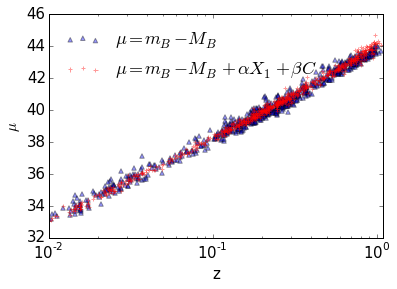

In [54]:
Mb = -19.0
alpha = 0.141
beta = 3.1

mu1 = t["mb"] - Mb
mu2 = t["mb"] - Mb + alpha * t["x1"] - beta * t["color"]

plt.scatter(t["zcmb"], mu1, label=r"$\mu = m_B - M_B$", alpha=0.4, marker="^")
plt.scatter(t["zcmb"], mu2, label=r"$\mu = m_B - M_B + \alpha X_1 + \beta C$", c="r", alpha=0.4, marker="+")

plt.xscale("log")
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0.01, 1.1)

plt.legend(loc=2, frameon=False)

plt.savefig("distance_modulus.jpg")

## Modelos Cosmológicos

Dado un modelo cosmológico determinado por:

- La constante de Hubble $H_0$
- La densidad de materia $\Omega_m$
- La densidad de radiación $\Omega_r$
- La densidad de curvatura $\Omega_k$
- La densidad de ernegía oscura $\Omega_\Lambda$

Se puede calcular la denominada distancia cosmológica a partir de las siguiente operaciones matemáticas

Definimos la distancia de Hubble:

$$D_H = \dfrac{c}{H_0}$$

Definimos el parámetro de Hubble

$$E(z) = [\Omega_r(1+z)^4 + \Omega_m(1+z)^3 + \Omega_k(1+z)^2 + \Omega_\Lambda]^{1/2}$$

La distancia comoviente puede calcularse como

$$d_c = D_H \int_0^z \dfrac{dz'}{E(z')}$$

Mientras que la distancia Transversa comoviente queda definida como

$$d_M = $$

Finalmente la distancia luminosa puede escribirse como

$$d_L = (1+z) d_M$$

Definimos algunos modelos cosmológicos arquetípicos para poder hacer una rápida comparación del efecto de cada parámetro

|Modelo              | $\Omega_m$  |  $\Omega_\Lambda$ | 
|--------------------|-------------|-------------------|
|Einstein - de Sitter| 1.0         |  0.0              |
|High lambda         | 0.3         |  0.7              |
|Low density         | 0.05        |  0.0              |


In [16]:
H0 = 70.0 * u.km / u.s / u.Mpc

DH = c / H0
DH = DH.to("Mpc")

Einstein_deSitter = FlatLambdaCDM(H0, 1.0, name="Einstein - de Sitter")
low_density = LambdaCDM(H0, 0.05, 0.0, name="Low density")
high_lambda = FlatLambdaCDM(H0, 0.3, name="High lambda")

En la siguiente figura podemos ver como resulta la distancia luminosidad en función del corrimiento al rojo para disitntos modleos cosmológicos

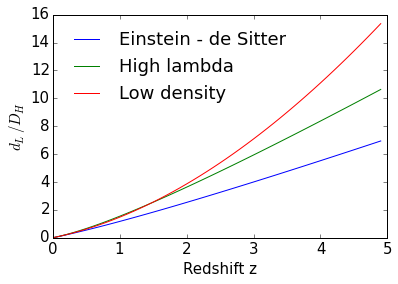

In [55]:
z = np.arange(0, 5, 0.1)

plt.plot(z, Einstein_deSitter.luminosity_distance(z)/DH, label="Einstein - de Sitter")
plt.plot(z, high_lambda.luminosity_distance(z)/DH, label="High lambda")
plt.plot(z, low_density.luminosity_distance(z)/DH, label="Low density")


plt.legend(loc=0, frameon=False)

plt.ylabel(r"$d_L/D_H$")
plt.xlabel("Redshift z")

plt.savefig("dlum.jpg")

In [18]:
def model_teo(z, cm, Mb=-19, alpha=0.141, beta=3.1):
    dL = cm.luminosity_distance(z)
    dL = dL.to("pc")
    
    mu = t["mb"] - Mb + alpha * t["x1"] - beta * t["color"]
    mu_model = 5 * np.log10(dL/(10 * u.pc))
    
    return mu, mu_model    

Asumiendo los valores fiduciarios para los coeficientes de corrección y tomando $H_0 = 70$ km s$^{-1}$ Mpc$^{-1}$ veamos como ajusta cada uno de los los modelos cosmoĺógicos de prueba a los datos

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


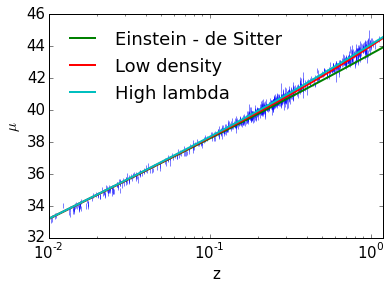

In [65]:
z = np.arange(0, 1.5, 0.01)

models = [Einstein_deSitter, low_density, high_lambda]

err = np.sqrt(tdmb**2 + alpha * tdx1**2 + beta * tdc**2)

mu, mu_model = model_teo(tz, models[0])
plt.errorbar(tz, mu, yerr=err, marker=".", linestyle="", capsize=0, markersize=0, alpha=0.5)

for m in models:
    mu, mu_model = model_teo(z, m)
    plt.plot(z, mu_model, label=m.name, linewidth=2)
    
plt.legend(loc=2, frameon=False)
plt.xscale("log")
plt.xlim(0.01, 1.2)

plt.xlabel("z")
plt.ylabel(r"$\mu$")

plt.savefig("model_compare.jpg")

A continuanción vamos a definir un modelo para ser ajustado mediante un esquema del tipo Markov Chain Monte Carlo (MCMC)

El ajuste de la constante de Hubble no puede ser realmente realizado con estos datos porque lo que mide el método de las supernovas tipo Ia son distancias relativas. Si podemos intentar obtener los parámetros cosmológicos relacionados con las densidad de radiación, curvatura, materia oscura y energía oscura.

Como el término de radiación en el factor de Hubble deja de ser dominante a redshifts bajos como los que estamos trabajando vamos a despreciar la densidad de radiación. Si además consideramos un universo plano, nos queda un sólo parámetro libre en nuestro modelo: la densidad de materia.

El método MCMC permite acomodar fácilmente distintos modelos con una catidad de parámetros libres variable. Entre los parámetros a considerar también debemos tener en cuenta los valores de los coeficientes de correción. 

En principio vamos a asumir priors uniformes para cada uno de los parámetros libres de nuestro modelo. Si deseamos obviar el ajuste de un parámetro por cualquier razón, simplemente podemos dejar el valor de ese parámetro constante durante todo el algoritmo de ajuste.



In [20]:
def model(values, observed):
    Omega_m = Uniform("Omega_m", 0.0, 1.0, value=values["Om0"], observed=observed["Om0"])
    H0 = Uniform("H0", 20.0, 100.0, value=values["H0"], observed=observed["H0"])

    Mb = Uniform("Mb", -30, 3.0, value=values["Mb"], observed=observed["Mb"])
    alpha = Uniform("alpha", -10.0, 10.0, value=values["alpha"], observed=observed["alpha"])
    beta = Uniform("beta", -10.0, 10.0, value=values["beta"], observed=observed["beta"])

    err = np.sqrt(tdmb**2 + alpha.value * tdx1**2 + beta.value * tdc**2)

    @deterministic(plot=False)
    def mu_correction(Mb=Mb, alpha=alpha, beta=beta):
        result = tmb - Mb + alpha * tx1 - beta * tc
        return result
    
    @deterministic(plot=False)
    def err(Mb=Mb, alpha=alpha, beta=beta):
        result = np.sqrt(tdmb**2 + alpha * tdx1**2 + beta * tdc**2)
        return result
    
    @deterministic(plot=False)
    def mu(Omega_m=Omega_m, H0=H0):
        cm = FlatLambdaCDM(H0=H0, Om0=Omega_m)
    
        dL = cm.luminosity_distance(tz)
        dL = dL.to("pc").value
        mu_model = 5 * np.log10(dL/(10))
    
        return mu_model
    
    y = Normal("y", mu-mu_correction, tau=1.0/err**2, value=np.zeros(tz.size), observed=True)
    
    result = locals()
    del result["values"]
    del result["observed"]
    
    return result

Modelo I (sin corrección)

Parámetros libres:

- $\Omega_m$
- $H_0$

Otros parámetros

- $\Omega_k = 0$
- $M_b = -19.0$
- $\alpha = 0.0$
- $\beta = 0.0$


In [21]:
values1 = {"Om0": 0.7, "H0": 70.0, "Mb": -19.0, "alpha": 0.0, "beta": 0.0}
observed1 = {"Om0": False, "H0": False, "Mb": True, "alpha": True, "beta": True}
m1 = Model(model(values1, observed1))


M1 = MCMC(m1, db="hdf5", dbname="m1.h5")
M1.use_step_method(AdaptiveMetropolis, M1.Omega_m)
M1.use_step_method(AdaptiveMetropolis, M1.H0)

In [22]:
# M1.sample(iter=100000, burn=10000, thin=100)

In [66]:
# M1.stats()

Plotting Omega_m
Plotting H0


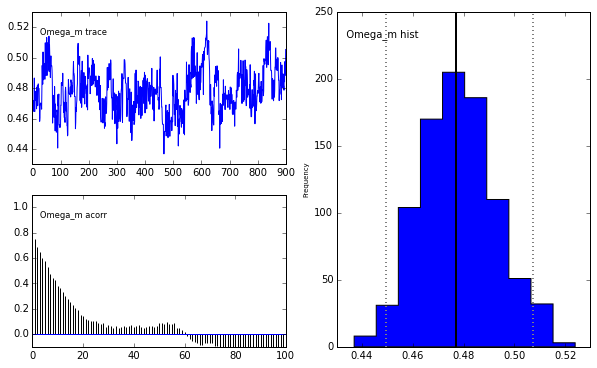

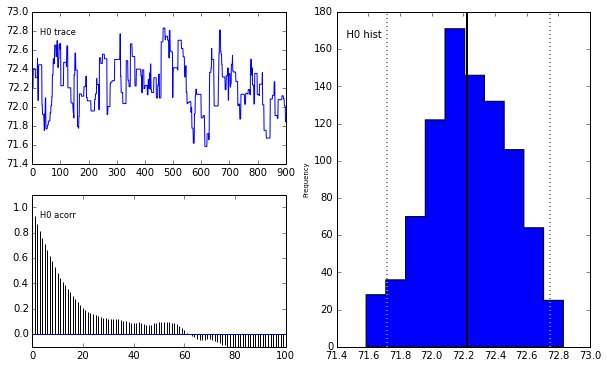

In [24]:
plot(M1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


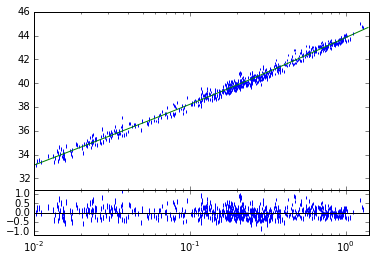

In [25]:
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

H0 = M1.db.H0.gettrace().mean()
Omega_m = M1.db.Omega_m.gettrace().mean()

cm = FlatLambdaCDM(H0=H0, Om0=Omega_m)

mu, mu_model = model_teo(tz, cm, alpha=0, beta=0)
res = mu - mu_model

alpha = 0.0
beta = 0.0
err = np.sqrt(tdmb**2 + alpha * tdx1**2 + beta * tdc**2)

ax1.errorbar(tz, mu, yerr=err, marker="s", linestyle="", markersize=0, capsize=0)

z = np.arange(0, 1.4, 0.01)
mu, mu_model_l = model_teo(z, cm, alpha=0, beta=0)

ax1.plot(z, mu_model_l)
ax1.set_xscale("log")

ax1.set_xlim([0.0, 1.4])
ax1.set_ylim([31, 46])


ax2.errorbar(tz, res, yerr=err, capsize=0, markersize=0, linestyle="")
ax2.set_xscale("log")

ax2.set_ylim([-1.2, 1.2])
ax2.axhline(0.0, c="k")

plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

Modelo II (con corrección)

Parámetros libres:

- $\Omega_m$
- $H_0$

Otros parámetros

- $\Omega_k = 0$
- $M_b = -19.0$
- $\alpha = 0.141$
- $\beta = 3.1$


In [26]:
values2 = {"Om0": 0.7, "H0": 70.0, "Mb": -19.0, "alpha": 0.141, "beta": 3.1}
observed2 = {"Om0": False, "H0": False, "Mb": True, "alpha": True, "beta": True}
m2 = Model(model(values2, observed2))

M2 = MCMC(m2, db="hdf5", dbname="m2.h5")
M2.use_step_method(AdaptiveMetropolis, M2.Omega_m)
M2.use_step_method(AdaptiveMetropolis, M2.H0)

In [27]:
# M2.sample(iter=100000, burn=10000, thin=100)

In [67]:
# M2.stats()

Plotting H0
Plotting Omega_m


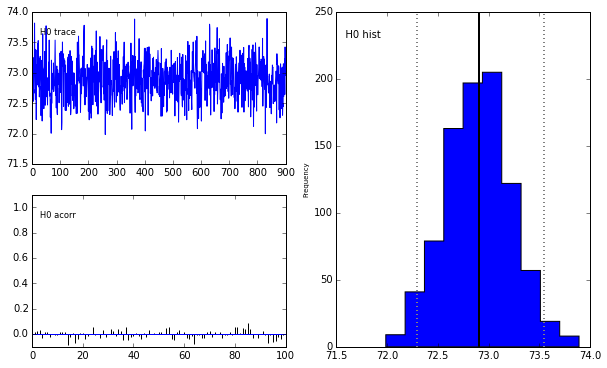

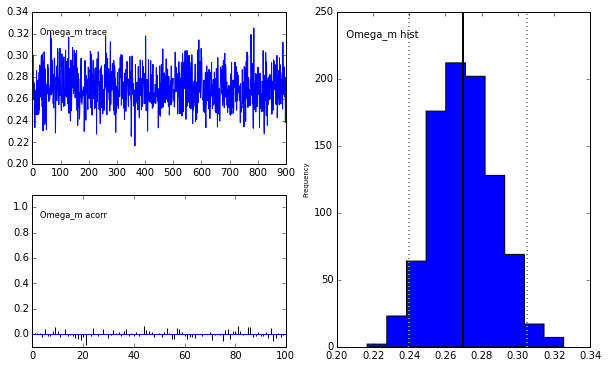

In [29]:
plot(M2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


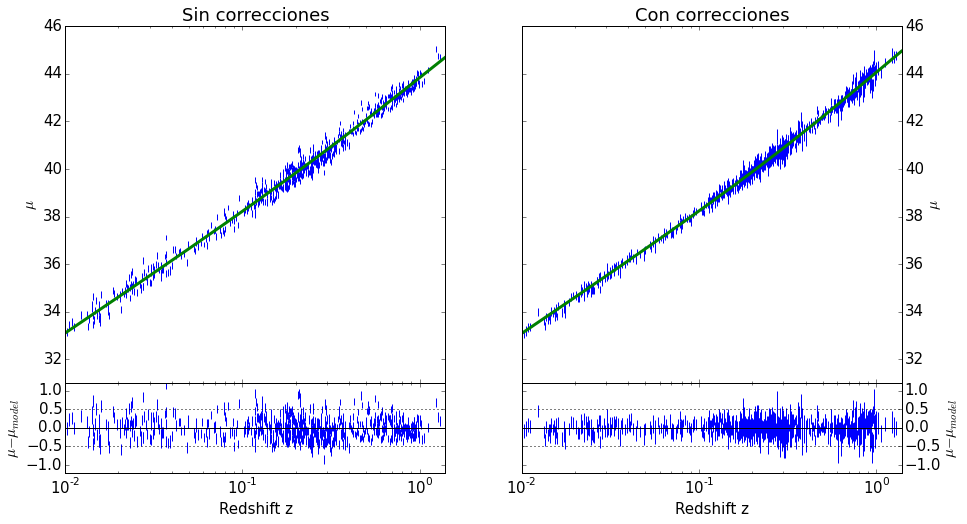

In [61]:
plt.figure(figsize=(15, 8))

models = [M1, M2]
alphas = [0.0, 0.141]
betas = [0.0, 3.1]

gs = gridspec.GridSpec(2, 2, height_ratios=[4, 1]) 

ax1s = [plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])]
ax2s = [plt.subplot(gs[1, 0], sharex=ax1s[0]), plt.subplot(gs[1, 1], sharex=ax1s[1])]

for M, alpha, beta, ax1, ax2 in zip(models, alphas, betas, ax1s, ax2s):

    H0 = M.db.H0.gettrace().mean()
    Omega_m = M.db.Omega_m.gettrace().mean()

    cm = FlatLambdaCDM(H0=H0, Om0=Omega_m)

    mu, mu_model = model_teo(tz, cm, alpha=alpha, beta=beta)
    res = mu - mu_model

    err = np.sqrt(tdmb**2 + alpha * tdx1**2 + beta * tdc**2)

    ax1.errorbar(tz, mu, yerr=err, marker="s", linestyle="", markersize=0, capsize=0)

    z = np.arange(0, 1.4, 0.01)
    mu, mu_model_l = model_teo(z, cm, alpha=0, beta=0)

    ax1.plot(z, mu_model_l, linewidth=3)
    ax1.set_xscale("log")

    ax1.set_xlim([0.0, 1.4])
    ax1.set_ylim([31, 46])


    ax2.errorbar(tz, res, yerr=err, capsize=0, markersize=0, linestyle="")
    ax2.set_xscale("log")

    ax2.set_ylim([-1.2, 1.2])
    ax2.axhline(0.0, c="k")
    ax2.axhline(0.5, c="k", linestyle=":")
    ax2.axhline(-0.5, c="k", linestyle=":")
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)
    
    ax2.set_xlabel("Redshift z")
    ax2.set_ylabel(r"$\mu - \mu_{model}$")
    ax1.set_ylabel(r"$\mu$")
    
    
#plt.setp(ax1s[1].get_yticklabels(), visible=False)
#plt.setp(ax2s[1].get_yticklabels(), visible=False)
ax1s[1].yaxis.tick_right()
ax1s[1].yaxis.set_ticks_position('both')
ax2s[1].yaxis.tick_right()
ax2s[1].yaxis.set_ticks_position('both')
ax1s[1].yaxis.set_label_position("right")
ax2s[1].yaxis.set_label_position("right")


ax1s[0].set_title("Sin correcciones")
ax1s[1].set_title("Con correcciones")

plt.savefig("residuos.jpg")

Modelo III (Ajuste de factores de corrección y constante cosmológica)

Parámetros libres:

- $\Omega_m$
- $H_0$
- $M_b$
- $\alpha$
- $\beta$


Otros parámetros

- $\Omega_k = 0$


In [31]:
values3 = {"Om0": 0.7, "H0": 70.0, "Mb": -19.0, "alpha": 0.141, "beta": 3.1}
observed3 = {"Om0": False, "H0": False, "Mb": False, "alpha": False, "beta": False}
m3 = Model(model(values3, observed3))

M3 = MCMC(m3, db="hdf5", dbname="m3.h5")
M3.use_step_method(AdaptiveMetropolis, M3.Omega_m)
M3.use_step_method(AdaptiveMetropolis, M3.H0)
M3.use_step_method(AdaptiveMetropolis, M3.Mb)
M3.use_step_method(AdaptiveMetropolis, M3.alpha)
M3.use_step_method(AdaptiveMetropolis, M3.beta)

In [32]:
# M3.sample(iter=100000, burn=10000, thin=100)

Plotting beta
Plotting H0
Plotting Mb
Plotting alpha
Plotting Omega_m


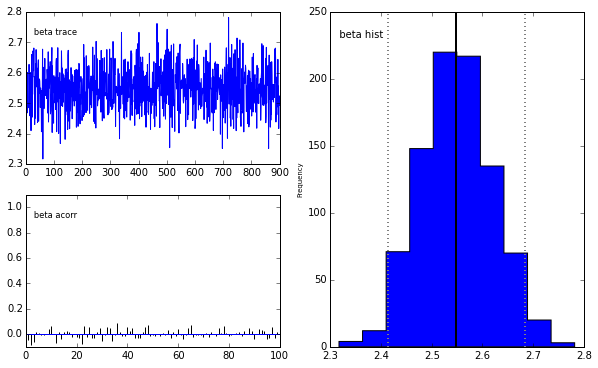

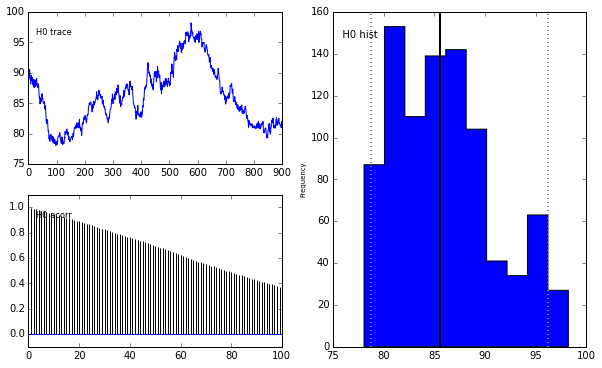

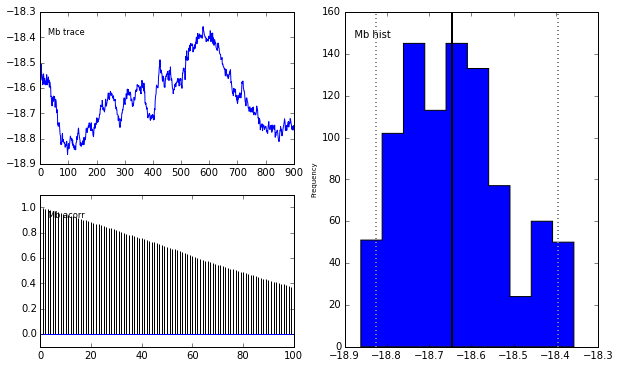

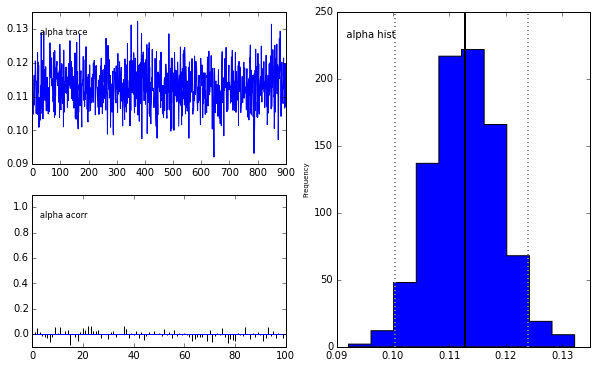

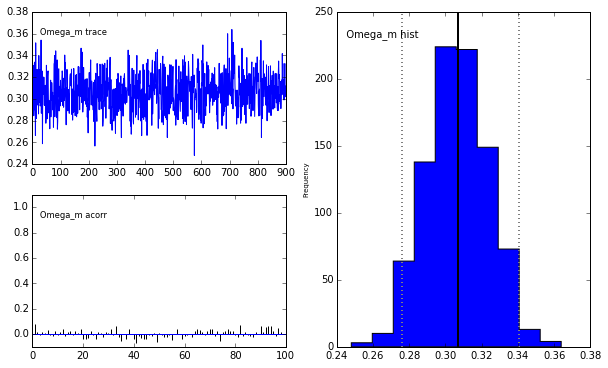

In [33]:
plot(M3)

Modelo IV (Ajuste de factores de corrección sin constante cosmológica)

Parámetros libres:

- $\Omega_m$
- $M_b$
- $\alpha$
- $\beta$


Otros parámetros

- $\Omega_k = 0$
- $H_0 = 70.0$


In [34]:
values4 = {"Om0": 0.7, "H0": 70.0, "Mb": -19.0, "alpha": 0.141, "beta": 3.1}
observed4 = {"Om0": False, "H0": True, "Mb": False, "alpha": False, "beta": False}
m4 = Model(model(values4, observed4))

M4 = MCMC(m4, db="hdf5", dbname="m4.h5")
M4.use_step_method(AdaptiveMetropolis, M4.Omega_m)
M4.use_step_method(AdaptiveMetropolis, M4.Mb)
M4.use_step_method(AdaptiveMetropolis, M4.alpha)
M4.use_step_method(AdaptiveMetropolis, M4.beta)

In [35]:
# M4.sample(iter=100000, burn=10000, thin=100)

In [68]:
# M4.stats()

Plotting alpha
Plotting Mb
Plotting Omega_m
Plotting beta


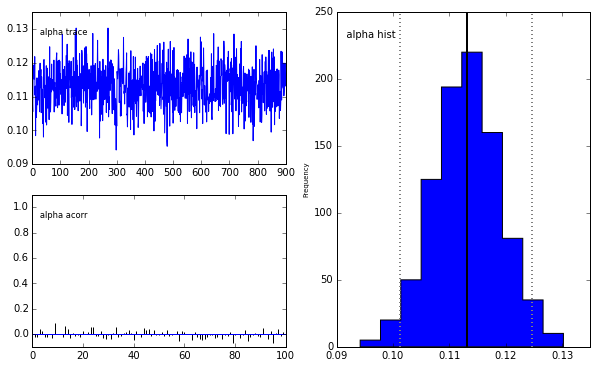

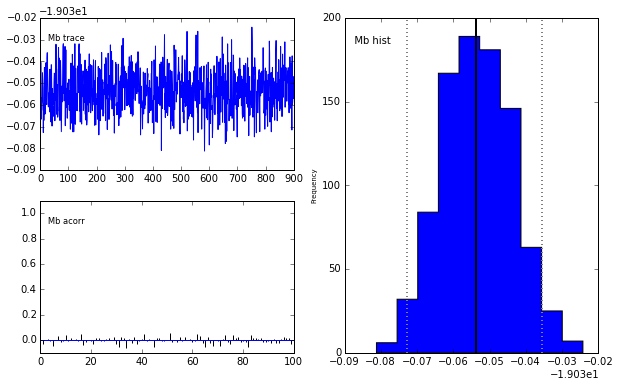

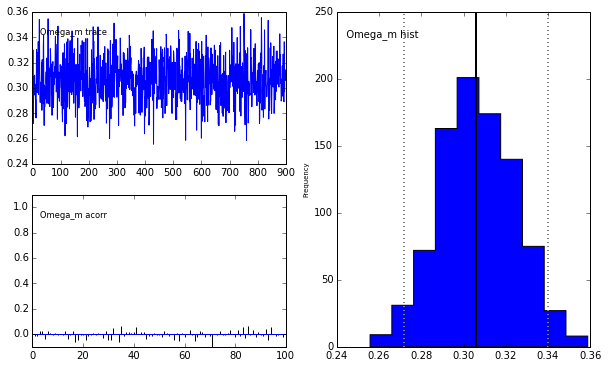

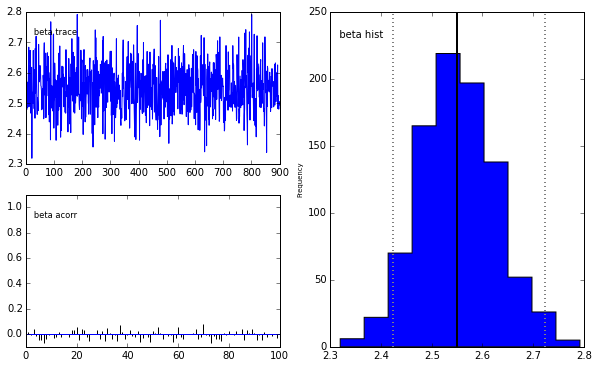

In [37]:
plot(M4)

Modelo V (Ajuste con curvatura)

Parámetros libres:

- $\Omega_m$
- $\Omega_\Lambda$
- $M_b$
- $\alpha$
- $\beta$


Otros parámetros

- $H_0 = 70.0$


In [38]:
@stochastic(dtype=np.dtype("float64"))
def omega(value=np.array([0.5, 0.5])):
    
    def logp(value):
        Z = value[0] + value[1]
        if Z > 1.0:
            return -np.inf
        elif value[0] < 0.0:
            return -np.inf
        elif value[1] < 0.0:
            return -np.inf
        else:
            return np.log(2.0)
    
    def random():
        x = uniform(0.0, 1.0)
        y = uniform(0.0, 1.0)
        if  x+y > 1.0:
            x = 1 - x
            y = 1 - y
        return np.array([x, y])

In [39]:
def model2(values, observed):
    Omega = omega
    H0 = Uniform("H0", 20.0, 100.0, value=values["H0"], observed=observed["H0"])

    Mb = Uniform("Mb", -30, 3.0, value=values["Mb"], observed=observed["Mb"])
    alpha = Uniform("alpha", -10.0, 10.0, value=values["alpha"], observed=observed["alpha"])
    beta = Uniform("beta", -10.0, 10.0, value=values["beta"], observed=observed["beta"])

    err = np.sqrt(tdmb**2 + alpha.value * tdx1**2 + beta.value * tdc**2)

    @deterministic(plot=False)
    def mu_correction(Mb=Mb, alpha=alpha, beta=beta):
        result = tmb - Mb + alpha * tx1 - beta * tc
        return result
    
    @deterministic(plot=False)
    def err(Mb=Mb, alpha=alpha, beta=beta):
        result = np.sqrt(tdmb**2 + alpha * tdx1**2 + beta * tdc**2)
        return result
    
    @deterministic(plot=False)
    def mu(Omega=Omega, H0=H0):
        Om0 = Omega[0]
        Ode0 = Omega[1]
        cm = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    
        dL = cm.luminosity_distance(tz)
        dL = dL.to("pc").value
        mu_model = 5 * np.log10(dL/(10))
    
        return mu_model
    
    y = Normal("y", mu-mu_correction, tau=1.0/err**2, value=np.zeros(tz.size), observed=True)
    
    result = locals()
    del result["values"]
    del result["observed"]
    
    return result

In [40]:
values5 = {"H0": 70.0, "Mb": -19.0, "alpha": 0.141, "beta": 3.1}
observed5 = {"H0": True, "Mb": False, "alpha": False, "beta": False}
m5 = Model(model2(values5, observed5))

M5 = MCMC(m5, db="hdf5", dbname="m5.h5")
M5.use_step_method(AdaptiveMetropolis, M5.Omega)
M5.use_step_method(AdaptiveMetropolis, M5.Mb)
M5.use_step_method(AdaptiveMetropolis, M5.alpha)
M5.use_step_method(AdaptiveMetropolis, M5.beta)

In [41]:
# M5.sample(iter=100000, burn=10000, thin=100)

Plotting Mb
Plotting omega_0
Plotting omega_1
Plotting alpha
Plotting beta


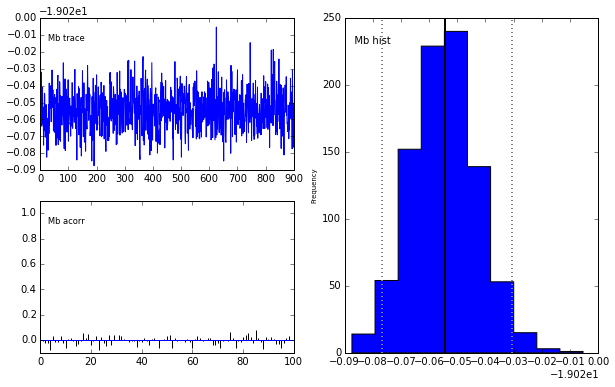

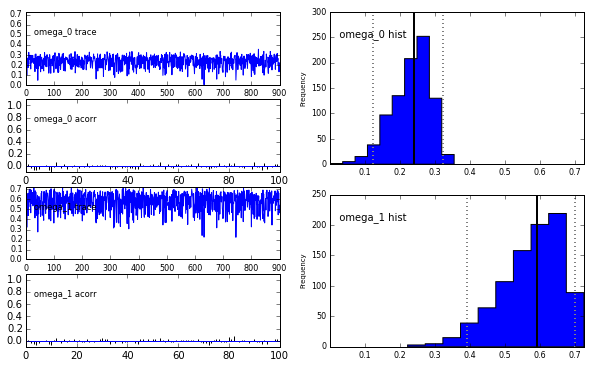

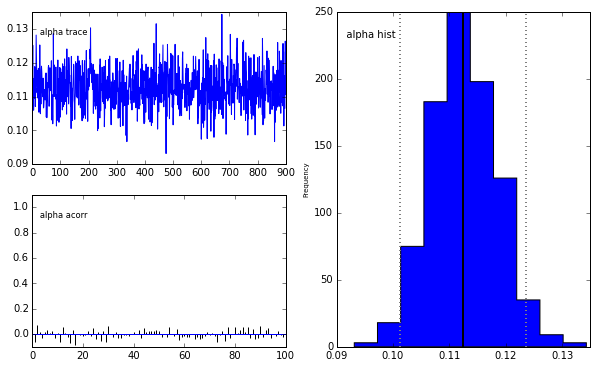

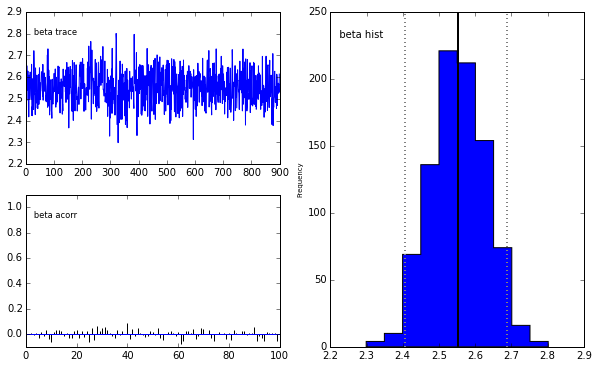

In [42]:
plot(M5)

In [43]:
def model3(values, observed):
    Omega_m = Uniform("Omega_m", 0.0, 1.0, value=values["Om0"], observed=observed["Om0"])
    Omega_l = Uniform("Omega_l", 0.0, 1.0, value=values["Ode0"], observed=observed["Ode0"])

    H0 = Uniform("H0", 20.0, 100.0, value=values["H0"], observed=observed["H0"])

    Mb = Uniform("Mb", -30, 3.0, value=values["Mb"], observed=observed["Mb"])
    alpha = Uniform("alpha", -10.0, 10.0, value=values["alpha"], observed=observed["alpha"])
    beta = Uniform("beta", -10.0, 10.0, value=values["beta"], observed=observed["beta"])

    err = np.sqrt(tdmb**2 + alpha.value * tdx1**2 + beta.value * tdc**2)

    @deterministic(plot=False)
    def mu_correction(Mb=Mb, alpha=alpha, beta=beta):
        result = tmb - Mb + alpha * tx1 - beta * tc
        return result
    
    @deterministic(plot=False)
    def err(Mb=Mb, alpha=alpha, beta=beta):
        result = np.sqrt(tdmb**2 + alpha * tdx1**2 + beta * tdc**2)
        return result
    
    @deterministic(plot=False)
    def mu(Omega_m=Omega_m, Omega_l=Omega_l, H0=H0):
        cm = LambdaCDM(H0=H0, Om0=Omega_m, Ode0=Omega_l)
    
        dL = cm.luminosity_distance(tz)
        dL = dL.to("pc").value
        mu_model = 5 * np.log10(dL/(10))
    
        return mu_model
    
    y = Normal("y", mu-mu_correction, tau=1.0/err**2, value=np.zeros(tz.size), observed=True)
    
    result = locals()
    del result["values"]
    del result["observed"]
    
    return result

In [44]:
values6 = {"Om0": 0.5, "Ode0": 0.5, "H0": 70.0, "Mb": -19.0, "alpha": 0.141, "beta": 3.1}
observed6 = {"Om0": False, "Ode0": False, "H0": True, "Mb": False, "alpha": False, "beta": False}
m6 = Model(model3(values6, observed6))

M6 = MCMC(m6, db="hdf5", dbname="m6.h5")
M6.use_step_method(AdaptiveMetropolis, M6.Omega_m)
M6.use_step_method(AdaptiveMetropolis, M6.Omega_l)
M6.use_step_method(AdaptiveMetropolis, M6.Mb)
M6.use_step_method(AdaptiveMetropolis, M6.alpha)
M6.use_step_method(AdaptiveMetropolis, M6.beta)

In [45]:
# M6.sample(iter=100000, burn=10000, thin=100)

In [69]:
# M6.stats()

Plotting beta
Plotting alpha
Plotting Mb
Plotting Omega_m
Plotting Omega_l


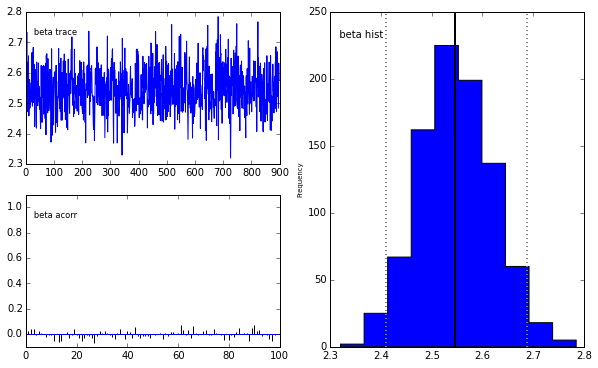

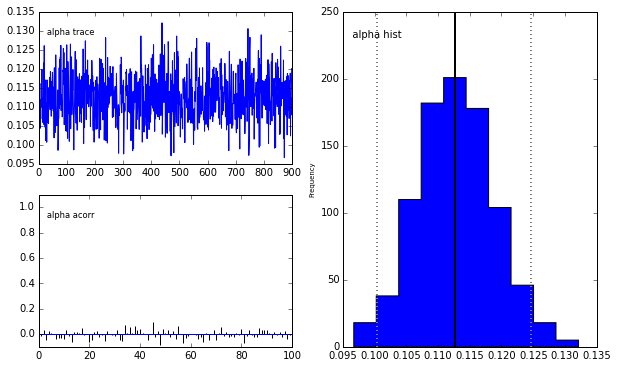

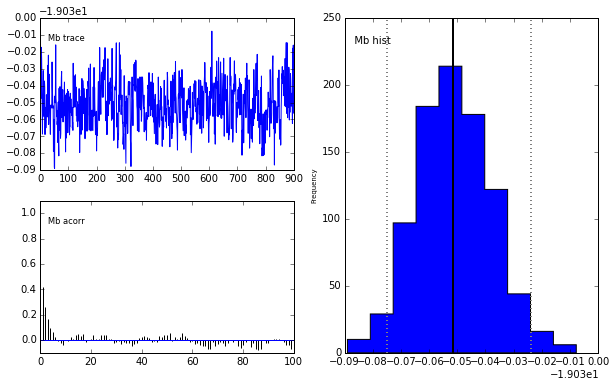

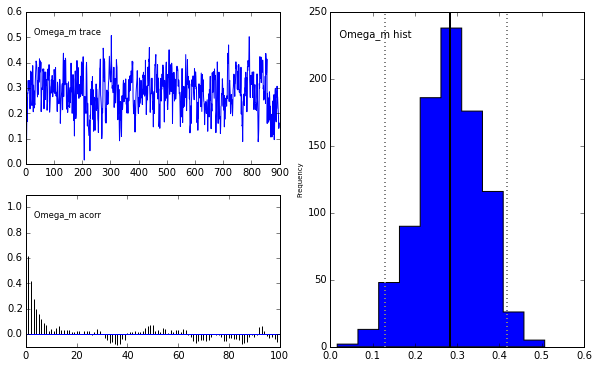

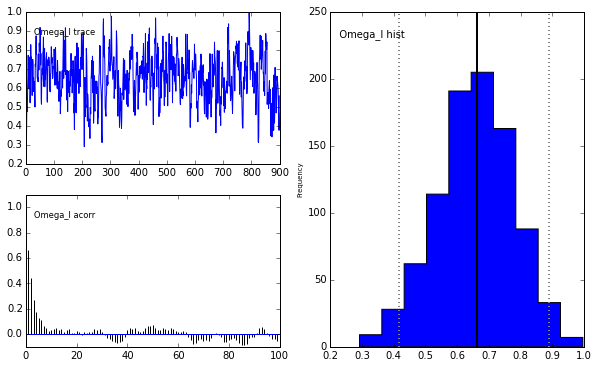

In [47]:
plot(M6)

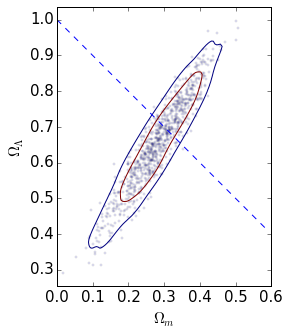

In [58]:
plt.figure(figsize=(5, 5))

x = np.arange(0, 0.6, 0.01)
plt.plot(x, 1-x, linestyle="--")

x = M6.db.Omega_m.gettrace()
y = M6.db.Omega_l.gettrace()

plt.scatter(x, y, alpha=0.1, edgecolor=None, s=4)

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

density2 = kernel(values)
ind = density2.argsort()[::-1]

sigma1 = int(68 * ind.size / 100.0)
sigma2 = int(95 * ind.size / 100.0)
s1_dens = density2[ind][sigma1]
s2_dens = density2[ind][sigma2]


density = kernel(positions)
Z = np.reshape(density.T, X.shape, )

plt.contour(X, Y, Z, levels=[s1_dens, s2_dens])

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\Lambda$")
plt.xlim(0.0, 0.6)

plt.axes().set_aspect('equal')

plt.savefig("scatter.jpg")